# Notes:
* IDs in dm_apps do not conflict with these IDs
    * confirm prior to import to full production Db
    * ALT: redo ID with another format
        * Kevin opinion: it would be nice to have the IDs look completely different between species for readability, but there may be reasons why 12-13 character ids are impractical
    * NB: since dates and sites are encoded into these ID, they may not be compatible with int filetypes
        * dm_apps looks to use char fields with max_length of 100, so should be fine... confirm
* CONFIRM: 
    * format of null samples when unmatched with fish details or length frequencies
    * required distict sample entry to link to for
        * fish details
        * length frequencies
    * no need for null fish details or length frequencies when unmatched with sample data
* WISHLIST
    * in dm_apps, it would be cool to be able to merge samples, or link with details/lengths (to deal with ambiguous data / partial matches)
    * in dm_apps, can we search for lengths/details, or do we need to find the correct sample?


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [2]:
# df_FD = pd.read_pickle('cleaned_MASTER_dataset.pickle')  # fish details
# df_LF = pd.read_pickle('cleaned_LENGTHFREQ_dataset.pickle')  # length frequencies
# df_SD = pd.read_pickle('cleaned_LOGBOOK_dataset.pickle')  # logbook / sample data

# ======================
# DATA CLEANING
# ======================

# FISH DETAILS

In [66]:
dtypes = {
    'YEAR': 'Int32', 
    'MM': 'Int32', 
    'DD': 'Int32', 
    'WEEK': 'Int32', 
    'SITE': 'object', 
    'PERIOD': 'object', 
    'CONDITION': 'object', 
    'FISH_NO': 'Int32', 
    'FL_WET': 'Int32', 
    'FL_FROZEN': 'object',  # error: Unable to parse string " ", covert to numeric manually
    'FL_STD': 'float64',
    'WEIGHT': 'float64',
    'SPECIES': 'object', 
    'SEX': 'object', 
    'MATURITY': 'object',  # error: Unable to parse string " ", covert to numeric manually
    'GONAD_WEIGHT': 'object',  # error: Unable to parse string " ", covert to numeric manually
    '1st Person Aging': 'object',  # error: could not convert string to float: ''
    'AGE': 'object',  # error: Unable to parse string "No Slide", covert to numeric manually
    'FSP': 'object',  # error: Unable to parse string " ", covert to numeric manually
    'Comments': 'object', 
    '2nd Person Aging': 'object', 
    'AGE.1': 'object',  # error: Unable to parse string ".", covert to numeric manually
    'FSP.1': 'object',  # error: Unable to parse string ".", covert to numeric manually
    'Comments.1': 'object', 
    'Envelop Comments': 'object'
} 

# initial data import
df_FD = pd.read_csv('csv_MASTER_Gaspereau_details_Larry.csv', dtype=dtypes)

# create backup of notes (including all numeric data for simplicity)
df_FD['AGE_notes'] = df_FD['AGE']
df_FD['FSP_notes'] = df_FD['FSP']

# convert to numeric and coerce errors (all non-numeric data converted to null)
df_FD['FL_FROZEN'] = pd.to_numeric(df_FD['FL_FROZEN'], errors='coerce').astype('Int32')
df_FD['MATURITY'] = pd.to_numeric(df_FD['MATURITY'], errors='coerce').astype('Int32')
df_FD['GONAD_WEIGHT'] = pd.to_numeric(df_FD['GONAD_WEIGHT'], errors='coerce')  # float
df_FD['AGE'] = pd.to_numeric(df_FD['AGE'], errors='coerce').astype('Int32')
df_FD['FSP'] = pd.to_numeric(df_FD['FSP'], errors='coerce').astype('Int32')
df_FD['AGE.1'] = pd.to_numeric(df_FD['AGE.1'], errors='coerce').astype('Int32')
df_FD['FSP.1'] = pd.to_numeric(df_FD['FSP.1'], errors='coerce').astype('Int32')

# add a DATETIME column
df_FD['DATETIME'] = pd.to_datetime(df_FD['YEAR'].astype(str) + '-' + df_FD['MM'].astype(str) + '-' + df_FD['DD'].astype(str))

### Cleaning categorical data

In [ ]:
df_FD.loc[df_FD.PERIOD == 'PM ', 'PERIOD'] = 'PM'
df_FD.loc[df_FD.CONDITION == 'FROZEN', 'CONDITION'] = 'Frozen'
df_FD.loc[df_FD.CONDITION == 'FRESH', 'CONDITION'] = 'Fresh'

### PERIOD: convert 'AD' to 'AM' - CONFIRM
* (118 entries)
* Other CSV also include AD periods for entered data

In [ ]:
confirm_AD_to_AM = False

if confirm_AD_to_AM:
    df_FD.loc[df_FD.PERIOD == 'AD', 'PERIOD'] = 'AM'

### FL_STD: null or scale - CONFIRM
* (264 entries)

In [ ]:
confirm_FL_STD_null = True
confirm_FL_STD_scale = False

# record indices of problems before transforming
index_FL_STD_problems = list(df_FD.loc[df_FD.FL_STD < 100, 'FL_STD'].index)

if confirm_FL_STD_null:
    df_FD.loc[df_FD.FL_STD < 100, 'FL_STD'] = np.nan
if confirm_FL_STD_scale:
    df_FD.loc[df_FD.FL_STD < 100, 'FL_STD'] = df_FD.loc[df_FD.FL_STD < 100, 'FL_STD'] * 10

### FL_WET and FL_FROZEN: null or scale - CONFIRM
* (5 entries)

In [ ]:
confirm_FL_WF_null = True
confirm_FL_WF_scale = False

# NOTE: indices from Excel are 1 indexed, not 0 indexed, and row 1 is the header
# therefore, the indices are off by 2
idx_dict = {
    35058-2: 100,
    35143-2: 10,
    35157-2: 100,
    35158-2: 100,
    35186-2: 100
}

# split these into variables to improve readability
indices = idx_dict.keys()
scale_factors = [idx_dict[k] for k in idx_dict.keys()]

if confirm_FL_WF_null:
    df_FD.loc[indices, 'FL_WET'] = np.nan
    df_FD.loc[indices, 'FL_FROZEN'] = np.nan
if confirm_FL_WF_scale:
    df_FD.loc[indices, 'FL_WET'] = df_FD.loc[indices, 'FL_WET'] * scale_factors
    df_FD.loc[indices, 'FL_FROZEN'] = df_FD.loc[indices, 'FL_FROZEN'] * scale_factors

### SEX: leave or null 'U' - CONFIRM
NOTE: there are 749 'U' in 1987 (way more than all other years combined (797))

In [67]:
confirm_SEX_U_null = False

if confirm_SEX_U_null:
     df_FD.loc[df_FD.SEX == 'U', 'SEX'] = np.nan

### SEX: leave or null 'B' - CONFIRM
* (only 1 entry)
* confirm B is not 'both' (if so, could change label to 'H' for hermaphrodite)

In [ ]:
confirm_SEX_B_null = False

if confirm_SEX_B_null:
    df_FD.loc[df_FD.SEX == 'B', 'SEX'] = np.nan
        
confirm_SEX_B_actually_H = False

if confirm_SEX_B_actually_H:
    df_FD.loc[df_FD.SEX == 'B', 'SEX'] = 'H'

### MATURITY: leave or null '44' - CONFIRM
* (only 1 entry)
* could also be typo for 4

In [ ]:
confirm_MATURITY_44_null = True

if confirm_MATURITY_44_null:
     df_FD.loc[df_FD.MATURITY == 44, 'MATURITY'] = np.nan
        
confirm_MATURITY_44_actually_4 = False

if confirm_MATURITY_44_null:
     df_FD.loc[df_FD.MATURITY == 44, 'MATURITY'] = 4

### WEIGHT: Nullify outliers - CONFIRM
* (6 entries)
* they all look real except 1934g fish which could be checked manually

In [ ]:
max_weight = 500

df_FD.loc[df_FD.WEIGHT > max_weight]

In [ ]:
confirm_WEIGHT_null = False 

if confirm_WEIGHT_null:
     df_FD.loc[df_FD.WEIGHT > max_weight, 'WEIGHT'] = np.nan
        
# DEAL WITH 1934g FISH MANUALLY
df_FD.loc[df_FD.WEIGHT > 1900, 'WEIGHT'] = np.nan

### GONAD_WEIGHT: Nullify outliers - CONFIRM
* (7 entries)

In [ ]:
max_gonad_weight = 200

df_FD.loc[df_FD.GONAD_WEIGHT > max_gonad_weight]

In [ ]:
confirm_GONAD_null = True  # all of these have gonads that weight more than the total weight

if confirm_GONAD_null:
     df_FD.loc[df_FD.GONAD_WEIGHT > max_gonad_weight, 'GONAD_WEIGHT'] = np.nan

### Validate weight to length ratio - CONFIRM

##### need to flag these and manually deal with them individually 


[4:25 PM] Fishman, David
would be based on length in cm and weight in g

<img style="float: left;" src=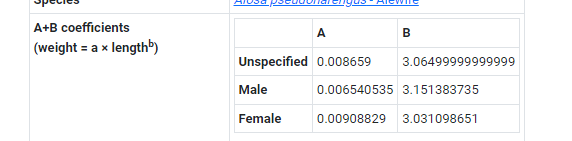>

In [68]:
def lw_prediction_delta(sex, length_mm, weight_g):
    """
    returns actual weight / predicted weight, based on length and sex
    """
    
    sex, length_mm, weight_g = str(sex), float(length_mm), float(weight_g)
    
    if sex.lower()[0] == 'm':
        A, B = 0.00654, 3.15
    elif sex.lower()[0] == 'f':
        A, B = 0.00909, 3.03
    else:
        A, B = 0.00866, 3.06
        
    # in grams, length converted mm to cm
    predicted_weight_g = A * ((length_mm / 10) ** B)
    
    return weight_g / predicted_weight_g


In [ ]:
df_FD['lw_ratio_check'] = 0.0

for i, row in df_FD.iterrows():
    try:
        df_FD.loc[i, 'lw_ratio_check'] = lw_prediction_delta(row['SEX'], row['FL_STD'], row['WEIGHT'])
    except KeyError:
        df_FD.loc[i, 'lw_ratio_check'] = np.nan
        
df_FD['lw_ratio_check'].describe(percentiles=[0.005, 0.995])

In [ ]:
# number of samples with extraordinary dimensions
avg_ratio = df_FD['lw_ratio_check'].describe()['mean']
stdev = df_FD['lw_ratio_check'].describe()['std']

lw_ratio_min, lw_ratio_max = avg_ratio - 3*stdev, avg_ratio + 3*stdev
df_FD[(df_FD['lw_ratio_check'] < lw_ratio_min) | (df_FD['lw_ratio_check'] > lw_ratio_max)].shape

In [ ]:
# these are our outliers
columns = ['CONDITION', 'FL_WET', 'FL_FROZEN', 'FL_STD', 'WEIGHT', 'SPECIES', 'SEX', 'MATURITY', 'GONAD_WEIGHT', 'AGE', 'lw_ratio_check']
df_FD[(df_FD['lw_ratio_check'] < lw_ratio_min) | (df_FD['lw_ratio_check'] > lw_ratio_max)].sort_values('lw_ratio_check')[columns]

### CONFIRM: whether any rows should be nulled/dropped/fixed

In [ ]:
# drop the lw_ratio_check before saving
df_FD = df_FD.drop('lw_ratio_check', axis=1)

# LENGTH FREQUENCIES

In [ ]:
df_LF = pd.read_csv(r'.\provided data\Margaree Gaspereau lgth-freq_Master.csv')

### Clean Date/Time and create DATETIME column

In [ ]:
# convert all times to same format, set missing times to 0000 (date only), then to datetime format
df_LF['CleanTime'] = df_LF['Time']
df_LF.loc[df_LF['CleanTime'] < 10, 'CleanTime'] = df_LF.loc[df_LF['CleanTime'] < 10, 'CleanTime'] * 100
df_LF['CleanTime'] = pd.to_datetime(df_LF.CleanTime, format='%H%M')

# all null times should be 0000 (which pandas reads as no time data)
# NOTE: incorporate AM/PM column?
df_LF.loc[df_LF['CleanTime'].isnull(), 'CleanTime'] = pd.to_datetime(0)  

df_LF['DATETIME'] = pd.to_datetime(dict(
    year=df_LF['yy'], 
    month=df_LF['mm'], 
    day=df_LF['dd'], 
    hour=df_LF['CleanTime'].dt.hour, 
    minute=df_LF['CleanTime'].dt.minute
), errors='coerce')

df_LF = df_LF.drop('CleanTime', axis=1)

### Clean River Column

In [ ]:
df_LF.loc[df_LF.river == 'SW Margaree', 'river'] = 'SW MARGAREE'
df_LF.river.unique()

### Expand and Clean Site Column
* Later analysis shows matching with samples on the first noted site is more effective than combining multiple sites. 
* Consider adding extra sites to notes column or adding the ability to select multiple sites when inputting a sample.

In [ ]:
df_LF[['SITE1', 'SITE2', 'SITE3']] = df_LF.site.str.replace(' ','').str.split(',', expand=True).fillna(pd.NA)

### Clean Location

In [ ]:
# clean the typos
df_LF.loc[df_LF['loc'] == 'LOWER ', 'loc'] = 'LOWER'
df_LF.loc[df_LF['loc'] == 'LOWE', 'loc'] = 'LOWER'
df_LF['loc'].unique()

### Period: AD left as is - CONFIRM

In [ ]:
df_LF.period.unique()

In [ ]:
# counts: AM, PM, and AD
# AD data are also included in the FISH DETAILS, assumed not a typo (although rare)
sum(df_LF.period == 'AM'), sum(df_LF.period == 'PM'), sum(df_LF.period == 'AD')

# SAMPLES (logbook)

In [ ]:
dtypes = {
    'code': 'object',
    'no_nets': 'object',
    'YEAR': 'Int32',
    'MM': 'Int32',
    'DD': 'Int32',
    'Week': 'Int32',
#     'hours_fished': 'Int32'  # some entries say 'maximum '
}
df = pd.read_csv(r'.\provided data\Margaree Gaspereau logbooks_Master.csv', dtype=dtypes)

In [ ]:
# clean NAME column









sorted(list(df.NAME.unique()))

In [ ]:
# create columns for multiple sites
df[['SITE1', 'SITE2']] = df.SITE_NO.str.split(',', expand=True).fillna(pd.NA)

In [ ]:
df['DATETIME'] = pd.to_datetime(
    df['YEAR'].astype(str) + '-' + df['MM'].astype(str) + '-' + df['DD'].astype(str), 
    errors='coerce'  # coerce missing days and months into errors
)
# any entries with missing month or day can't get an exact datetime
sum(df.DATETIME.isnull())

# ======================
# FORMATING FOR IMPORT
# ======================

* ALLCAPS: denotes columns that aren't perfect matches
* lowercase: denotes columns that should match perfectly with herring tables in dm_apps

# LENGTH FREQUENCIES
### Generate Unique IDs to Import / match with Samples

In [3]:
# replace non-numeric data with made up site numbers
# NOTE: These are converted back in import script
id_replacements = {
    '1A': 90,
    '1B': 91,
    'EricMcFarlane': 92,
    'JimmyMacFarlane': 93,
    'JohnAlbertCoady': 94
}
df_LF = df_LF.replace({'SITE1': id_replacements})

In [4]:
# 'unique' id column (note ambiguities, and solve later)
df_LF['id'] = (
    df_LF.DATETIME.dt.year*1_000_000 
    + df_LF.DATETIME.dt.month*10_000 
    + df_LF.DATETIME.dt.day*100 
    + df_LF.SITE1.fillna(0).astype(int)
).astype('Int64')

# new sample indicator
df_LF['new_sample'] = df_LF.lgth.diff() < 0

# new id indicator
df_LF['new_id'] = df_LF.id.diff() != 0

In [5]:
# update ids for ambiguous entries
duplicated_ids_LF = list(df_LF[~df_LF.new_id & df_LF.new_sample].id)

In [6]:
if df_LF.id.max() < 2_100_000_000: # only run this once

    # add 1B to duplicate ids
    df_LF.loc[df_LF.id.isin(duplicated_ids_LF), 'id'] = df_LF.loc[df_LF.id.isin(duplicated_ids_LF), 'id'] + 1_000_000_000

    # add an extra billion to every other id, so that all are now distinct
    previous_lgth = 0
    multiplier = False

    for i, row in df_LF[df_LF.id > 2_900_000_000].iterrows():

        current_lgth = row['lgth']
        if previous_lgth > current_lgth:
            multiplier = not multiplier

        df_LF.loc[i, 'id'] = row.id + 1_000_000_000*multiplier

        previous_lgth = current_lgth

### Length Bins

In [9]:
# use the same bins as used in the herring database (cm, grouped by 0.5s)
df_LF['length_bin_id'] = (df_LF.lgth - df_LF.lgth % 5) / 10

### LENGTH FREQUENCY 
### FINAL TABLE FOR IMPORT INTO DM_APPS

In [11]:
gaspereau_lengthfrequency = df_LF.groupby(['id', 'length_bin_id']).sum('freq').reset_index()[['freq', 'length_bin_id', 'id']].rename({
    'freq': 'count', 
    'length_bin_id': 'length_bin_id', 
    'id': 'sample_id'
}, axis=1)

# FISH DETAILS

In [25]:
# replace non-numeric data with made up site numbers
id_replacements_v2 = {
    '1A': 90,
    '1B': 91,
    'Eric MacFarlane': 92,
    'E.MACFARLANE': 92,
    'J McFarlane': 93,
    'JA Coady': 94,
    '11K3 (435,211)': 95, 
    '47 or 62': 47
}

# same site replacements from LF
df_FD['SITE1'] = df_FD.replace({'SITE': id_replacements_v2}).SITE
df_FD[['SITE1', 'SITE2', 'SITE3']] = df_FD.SITE1.str.replace(' ','').str.split(',', expand=True).fillna(pd.NA)

df_FD['sample_id'] = (
    df_FD.YEAR.astype(int)*1_000_000 
    + df_FD.MM.fillna(0).astype(int)*10_000
    + df_FD.DD.fillna(0).astype(int)*100
    + df_FD.SITE1.fillna(0).astype(int)
).astype('Int64')

### FISH DETAILS
### FINAL TABLE FOR IMPORT INTO DM_APPS

In [32]:
"""uses all detail-related data available - doesn't match well with herring_fishdetail table"""

# ALL CAPS used for unmatched fields
rename_FD = {
    'SITE1': 'SITE', 'FISH_NO': 'fish_number', 'FL_STD': 'fish_length', 
    'WEIGHT': 'fish_weight', 'MATURITY': 'maturity_id',
    'GONAD_WEIGHT': 'gonad_weight', '1st Person Aging': 'AGING_PERSON_1', 'AGE': 'AGE_1', 'FSP': 'FSP_1', 
    'Comments': 'AGE_COMMENTS_1', '2nd Person Aging': 'AGING_PERSON_2', 'AGE.1': 'AGE_2', 'FSP.1': 'FSP_2', 
    'Comments.1': 'AGE_COMMENTS_2', 'Envelop Comments': 'ENVELOP_COMMENTS', 'AGE_notes': 'AGE_NOTES', 'FSP_notes': 'FSP_NOTES'
}

gaspereau_fishdetails = df_FD[[
    'sample_id','DATETIME', 'SITE1',
    'CONDITION', 'FISH_NO', 'FL_WET', 'FL_FROZEN', 'FL_STD', 'WEIGHT', 'SPECIES', 'SEX', 'MATURITY', 
    'GONAD_WEIGHT', '1st Person Aging', 'AGE', 'FSP', 'Comments', '2nd Person Aging', 'AGE.1', 'FSP.1', 'Comments.1', 
    'Envelop Comments', 'AGE_notes', 'FSP_notes'
]].rename(columns=rename_FD)

# SAMPLES

In [15]:
# same site replacements from LF
df_SD = df_SD.replace({'SITE1': id_replacements})

# 'unique' id column
df_SD['id'] = (
    df_SD.YEAR.astype(int)*1_000_000 
    + df_SD.MM.fillna(0).astype(int)*10_000
    + df_SD.DD.fillna(0).astype(int)*100
    + df_SD.SITE1.fillna(0).astype(int)
).astype('Int64')

# duplicated ids
duplicated_ids_SD = set(df_SD[df_SD.duplicated('id', keep=False)].id)

In [16]:
# some of these ids end up with an extra digit
if df_SD.id.max() < 2_100_000_000:
    
    # initialise number of handled repeats as zero for each id
    n_repeats = dict(zip(duplicated_ids_SD, [0 for x in duplicated_ids_SD]))
    
    for i, row in df_SD[df_SD.id.isin(duplicated_ids_SD)].iterrows():
        df_SD.loc[i, 'id'] = row['id'] + 1_000_000_000 * int(n_repeats[row['id']] + 1)
        n_repeats[row['id']] += 1

### CONFIRM:  add null sample data where there is unmatched length frequencies and fish details
* if these null data are added, all fish detail and length frequencies should get into dm_apps
* if null data are not added, unmatched fish detail and length frequencies will be added to rejected files (csv generated on import)

In [20]:
# how many length frequency measurements are matched with samples?
# apprx 80%
(
    df_LF[df_LF.id.isin(set(df_SD.id))].id.nunique(), 
    df_LF.id.nunique(), 
    df_LF[df_LF.id.isin(set(df_SD.id))].id.nunique() / df_LF.id.nunique()
)

(731, 917, 0.797164667393675)

In [26]:
# how many fish detail sample ids are matched with samples id column?
# apprx 95%
(
    df_FD[df_FD.sample_id.isin(set(df_SD.id))].sample_id.nunique(), 
    df_FD.sample_id.nunique(), 
    df_FD[df_FD.sample_id.isin(set(df_SD.id))].sample_id.nunique() / df_FD.sample_id.nunique()
)

(1052, 1106, 0.9511754068716094)

In [21]:
# CONFIRM
add_null_data_where_unmatched = False

if add_null_data_where_unmatched:
    # add null samples where no match exists
    df_SD = pd.concat([df_SD, pd.DataFrame(df_LF[~df_LF.id.isin(set(df_SD.id))].id.unique(), columns=['id'])]).reset_index(drop=True)

    # NOTE: if a datetime column is useful in this null data, pd.to_datetime(id // 100) should work
    # alt could use a more complicated JOIN to add SITE1 as well
    # leave this way for now

    df_SD = pd.concat([df_SD, pd.DataFrame(df_FD[~df_FD.sample_id.isin(set(df_SD.id))].sample_id.unique(), columns=['id'])]).reset_index(drop=True)
    # again, a few more details could be added, but leave for now because the sample data is incomplete either way

### SAMPLE DATA
### FINAL TABLE FOR IMPORT INTO DM_APPS

In [30]:
"""uses all sample-related data available - doesn't match well with herring_sample table"""

# ALL CAPS FOR UNMATCHED / NEW
rename_SD = {
    'DATETIME': 'sample_date', 'DIST': 'district_id', 'RIVER': 'fishing_area_id', 
    'NAME': 'SAMPLER', 'code': 'CODE', 'GEAR': 'gear_id', 'SITE1': 'SITE',
    'no_nets': 'NO_NETS', 'catch_lbs': 'catch_weight_lbs', 'hours_fished': 'HOURS_FISHED', 
    'zone': 'ZONE', 'last_name': 'LAST_NAME', 'comments': 'COMMENTS',
    'bycatch_sbass': 'BYCATCH_SBASS', 'bycatch_shad': 'BYCATCH_SHAD', 'bycatch_other': 'BYCATCH_OTHER', 
    'wt_lbs': 'sample_weight_lbs'
}

gaspereau_sample = pd.merge(
    df_SD[[
        'id', 'DATETIME', 'DIST', 'RIVER', 'NAME', 'code', 'GEAR', 'SITE1', 'no_nets', 'catch_lbs', 'hours_fished', 
        'zone', 'last_name', 'comments', 'bycatch_sbass', 'bycatch_shad', 'bycatch_other'
    ]], 
    df_LF[['id', 'wt_lbs']],
    on='id', 
    how='left'  # all samples 
).drop_duplicates().reset_index(drop=True).rename(columns=rename_SD)

# SAVE TABLES

In [34]:
# save pickle files
if True:  # change this to overwrite/resave
    gaspereau_lengthfrequency.to_pickle('gaspereau_lengthfrequency.pickle')
    gaspereau_fishdetails.to_pickle('gaspereau_fishdetails.pickle')
    gaspereau_sample.to_pickle('gaspereau_sample.pickle')

# save csv for import into django
if True:  # change this to overwrite/resave
    gaspereau_lengthfrequency.to_csv('gaspereau_lengthfrequency.csv')
    gaspereau_fishdetails.to_csv('gaspereau_fishdetails.csv')
    gaspereau_sample.to_csv('gaspereau_sample.csv')